In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import scipy.io as sio
%matplotlib inline
from collections import defaultdict

In [3]:
def video_frame_generator(filename):

    # Todo: Open file with VideoCapture and set result to 'video'. Replace None
    video = cv2.VideoCapture(filename)

    # Do not edit this while loop
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            yield frame
        else:
            break

    # Todo: Close video (release) and yield a 'None' value. (add 2 lines)
    #raise NotImplementedError
    video.release()
    yield None

In [4]:
VID_DIR='./RGB'
def reading_video(video_name, fps, frame_ids, output_prefix,
                            counter_init):

    video = os.path.join(VID_DIR, video_name)
    image_gen = video_frame_generator(video)

    image = image_gen.next()
    h, w, d = image.shape

    out_path = "output/ar_{}-{}".format(output_prefix[4:], video_name)
    video_out = mp4_video_writer(out_path, (w, h), fps)

    output_counter = counter_init

    frame_num = 1

    while image is not None:

        print("Processing fame {}".format(frame_num))
        plt.imshow(image)
        

        video_out.write(image)

        image = image_gen.next()

        frame_num += 1

    #video_out.release()



In [5]:
#reading_video('a1_s1_t1_color.avi',15,1,'',1)
from mpl_toolkits.mplot3d import Axes3D

In [6]:
mat_contents = sio.loadmat('Skeleton/a1_s1_t1_skeleton.mat')

In [7]:
d_skel=mat_contents["d_skel"]

In [8]:
len(d_skel)

20

In [9]:
d_skel.shape

(20, 3, 48)

In [10]:
joint = d_skel[:,:,0]
joint[:,0]

array([-0.04576265, -0.03456692, -0.03057881, -0.02558481, -0.19882302,
       -0.23827337, -0.23610309, -0.22907546,  0.13442045,  0.19114332,
        0.2161559 ,  0.21803801, -0.09879873, -0.11512723, -0.07356355,
       -0.10780371,  0.05104091,  0.07187957,  0.0516578 ,  0.09826498])

Text(0.5,0,'Z')

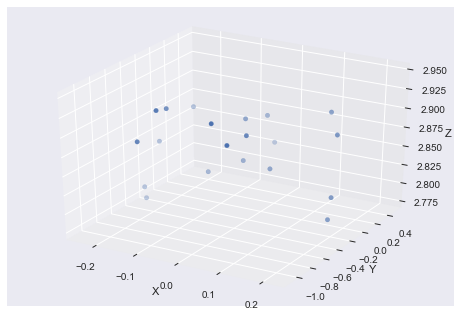

In [11]:
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.pbaspect = [1, 1, 1]
#ax.scatter(joint[:,0],joint[:,1],joint[:,2])
X,Y,Z=joint[:,0],joint[:,1],joint[:,2]

ax.scatter(X,Y,Z)


ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

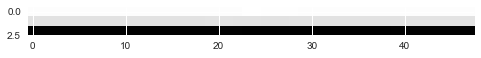

In [12]:
plt.imshow(d_skel[0])

In [13]:
import os
def load_training_data():
    dir_path = "Skeleton"
    files = os.listdir(dir_path)
    all_data = [] 
    for ii, file in enumerate(files, 1):
        #print(ii, file)
        if file.endswith(".mat"):
            mat_contents = sio.loadmat(dir_path+'/'+file)
            d_skel=mat_contents["d_skel"]
            action = file.split("_")[0]
            all_data.append((d_skel,action))
    print(len(all_data))
    return all_data
            

In [14]:
all_actions=["a"+str(num) for num in range(1,28)]
print(all_actions)

split_at = 26 #as each data contains 32 records so 26 for training and 6 for test


['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27']


In [15]:

def split_data(all_data, all_actions,split_at):
    ddct = defaultdict(list)
    training_data=[]
    testing_data=[]
    for X,y in all_data:
        for action in all_actions:
            if(action == y):
                ddct[action].append(1)
                if len(ddct[action]) < split_at+1:
                    training_data.append((X,y))
                else:
                    testing_data.append((X,y))
    return training_data, testing_data
                

In [16]:
all_data = load_training_data()
training_data, testing_data = split_data(all_data,all_actions,26)

861


In [17]:
print("training.." , len(training_data))
print("testing.." , len(testing_data))

training.. 702
testing.. 159


In [18]:
def fetch_training_data_by_action(records,action):
    action_pairs=[]
    for X,y in records:
        if y == action:
            action_pairs.append((X,y))
    return action_pairs
        

In [19]:
a1_actions = fetch_training_data_by_action(training_data,'a1')
print(len(a1_actions))

26


In [20]:
a1_actions[25][0].shape

(20, 3, 69)

In [21]:
# #all_data[0]
# from sklearn.model_selection import train_test_split
# X,y = zip(*all_data)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
# print(len(X_train),len(y_train),len(X_test),len(y_test))
# print(y_train[0])

Lets train individual action

In [24]:
def train_an_action(action, num_hidden_states, features,lengths):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)  
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000,random_state=123,params="ct").fit(features,lengths)
    logL = model.score(features,lengths)
    return model, logL


Lets extract features

In [244]:
def extact_features_skelton(records,action):
    all_features,_ = zip(*fetch_training_data_by_action(records,action))
    print(len(all_features))
    
    delta_records=[]
    for record in all_features:
        rec_length = record.shape[2]
        diffs=[]
        for idx in range(1,rec_length):
            diff_x = record[:,0,idx] - record[:,0,idx-1]
            diff_y = record[:,1,idx] - record[:,1,idx-1]
            diff_z = record[:,2,idx] - record[:,2,idx-1]
            diffs.append(np.sqrt(np.square(diff_x)+np.square(diff_y)+np.square(diff_z)))
        delta_records.append(np.array(diffs))
    print(all_features[0].shape)
    print(np.array(delta_records[0]).shape)
    return np.array(delta_records)
    #print(delta_records[0])

In [210]:
new_features_skel = extact_features_skelton(training_data,'a1')

26
(20, 3, 72)
(71, 20)


In [228]:
def get_hmm_formatted_features(records,no_features,action):
    x_contatinated = np.zeros((1,no_features))
    lengths=[]
    
    #actions = fetch_training_data_by_action(records,action)
    #action_features,_ = zip(*actions)
    action_features = extact_features_skelton(records,action)
    print("length",len(action_features))
    #print(action_features[0].shape)
    
    
    for subject_action in list(action_features):
        lengths.append(subject_action.shape[0])
        x_contatinated = np.append(x_contatinated,subject_action,axis=0)

    
    x_contatinated = np.delete(x_contatinated, 0, axis=0)
    print(np.array(x_contatinated).shape)
    print(lengths)
    return np.array(x_contatinated),lengths

In [229]:
X,leangths = get_hmm_formatted_features(training_data,20,'a1')
model, logL = train_an_action('a1', 3, X ,leangths)

26
(20, 3, 72)
(71, 20)
length 26
(1560, 20)
[59, 71, 67, 75, 54, 55, 62, 58, 57, 49, 70, 55, 51, 47, 55, 62, 60, 52, 54, 70, 51, 55, 69, 71, 63, 68]


In [230]:
print("Number of states trained in model for {} is {}".format('a1', model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for a1 is 3
logL = 119635.60729003088


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state. The log likelihood for any individual sample or group of samples can also be calculated with the score method.

In [231]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats('a1', model)

Number of states trained in model for a1 is 3
hidden state #0
mean =  [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.02  0.02
  0.    0.    0.    0.01  0.    0.    0.    0.  ]
variance =  [  1.15e-05   1.75e-05   9.49e-06   8.55e-06   1.77e-05   1.25e-05
   1.18e-05   1.99e-05   3.60e-05   6.95e-04   2.11e-03   2.63e-03
   9.79e-06   1.09e-05   1.05e-05   1.10e-04   9.46e-06   1.22e-05
   1.01e-05   6.53e-05]

hidden state #1
mean =  [ 0.    0.01  0.    0.    0.01  0.    0.    0.    0.01  0.05  0.09  0.11
  0.    0.    0.    0.01  0.    0.    0.    0.  ]
variance =  [  1.29e-04   4.14e-04   5.53e-05   5.36e-05   3.44e-04   1.15e-04
   1.11e-04   1.32e-04   2.72e-04   1.14e-03   2.63e-03   3.13e-03
   6.50e-05   1.38e-04   1.39e-04   3.10e-04   6.27e-05   1.37e-04
   6.05e-05   9.39e-05]

hidden state #2
mean =  [  3.29e-03   4.43e-03   1.41e-03   3.08e-03   2.34e-02   6.34e-03
   3.69e-03   1.99e-02   4.45e-02   3.52e-01   6.19e-01   6.49e-01
   1.28e-02   9.29e-04   7

### Visualize the hidden states

In [222]:
import matplotlib.pyplot as plt

%matplotlib inline

In [223]:
import math
from matplotlib import (cm, pyplot as plt, mlab)
def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        


In [225]:
#visualize('a1', model)

In [232]:
all_sequences={}
all_lengths={}
actions= ['a1','a2','a3']

for action in actions:
    X,lengths = get_hmm_formatted_features(training_data,20,action)
    all_sequences[action] = X
    all_lengths[action]=lengths

26
(20, 3, 72)
(71, 20)
length 26
(1560, 20)
[59, 71, 67, 75, 54, 55, 62, 58, 57, 49, 70, 55, 51, 47, 55, 62, 60, 52, 54, 70, 51, 55, 69, 71, 63, 68]
26
(20, 3, 51)
(50, 20)
length 26
(1548, 20)
[67, 50, 57, 61, 66, 69, 70, 51, 62, 57, 55, 60, 69, 51, 59, 56, 68, 73, 53, 58, 49, 74, 53, 54, 52, 54]
26
(20, 3, 49)
(48, 20)
length 26
(1679, 20)
[63, 48, 54, 62, 66, 59, 60, 57, 60, 74, 68, 63, 69, 80, 71, 66, 79, 61, 56, 62, 56, 65, 65, 71, 73, 71]


Lets test for all actions

In [233]:
import time
import timeit
# autoreload for automatically reloading changes made in model_selectors
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
def train_all_actions(actions):
    models={}
    for action in actions:
        print("training for ",action)
        X = all_sequences[action]
        print(X.shape)
        lengths = all_lengths[action]
        model, logL = train_an_action(action, 4, X ,lengths)
        models[action]=model
        #time.sleep(2)
    return models

In [255]:
models = train_all_actions(actions)

training for  a1
(1560, 20)
training for  a2
(1548, 20)
training for  a3
(1679, 20)


In [236]:
models.keys()

dict_keys(['a1', 'a2', 'a3'])

In [37]:
## Lets test on known action first

In [237]:

def recognize_actions(features):
    probabilities = []
    guesses = []


    print('Started recognizing ...')
    
    bestLL = float("-inf")
    bestAction = None
    probs = {}
    for action, model in models.items():
        try:
            ll = model.score(features)
            if ll > bestLL:
                    bestLL = ll
                    bestAction = action
                    probs[action] = ll
        except:
            print(" ! ",end=" ")
            pass
    
    guesses.append(bestAction)
    probabilities.append(probs)
    return guesses,probabilities


In [238]:

test_AsX,test_A3sL = get_hmm_formatted_features(testing_data,20,'a1')
pr1 =models['a1'].score([test_AsX[0],test_AsX[1]])
pr2 =models['a2'].predict([test_AsX[0],test_AsX[1]])
pr3 =models['a3'].predict([test_AsX[0],test_AsX[1]])
print(sum(models['a1'].predict([test_AsX[0],test_AsX[1]])))
print(pr1)
print(sum(pr2))
print(models['a2'].score([test_AsX[0],test_AsX[1]]))
print(sum(pr3))
print(models['a3'].score([test_AsX[0],test_AsX[1]]))
print(models['a1'].predict([test_AsX[0],test_AsX[1]]))
print(models['a2'].predict([test_AsX[0],test_AsX[1]]))
print(models['a3'].predict([test_AsX[0],test_AsX[1]]))

6
(20, 3, 56)
(55, 20)
length 6
(360, 20)
[57, 55, 54, 65, 61, 68]
4
166.984206591
4
162.513769752
10
163.321683463
[2 2]
[2 2]
[5 5]


/usr/local/anaconda3/envs/nus/lib/python3.6/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/usr/local/anaconda3/envs/nus/lib/python3.6/site-packages/hmmlearn/base.py:452: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_), framelogprob)


In [239]:
sample_feature = get_hmm_formatted_features(testing_data,20,'a1')
test_AsX,test_A3sL = sample_feature
recognize_actions([test_AsX[0],test_AsX[1]])

6
(20, 3, 56)
(55, 20)
length 6
(360, 20)
[57, 55, 54, 65, 61, 68]
Started recognizing ...


/usr/local/anaconda3/envs/nus/lib/python3.6/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


(['a1'], [{'a1': 166.98420659139904}])

## Calculate Accuracy

In [240]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [256]:
test_actions=["a1","a2","a3"]
predicted=[]
actual=[]

for Xs,ys in [(Xs,ys) for Xs,ys in testing_data if ys in test_actions]:
    X,L = get_hmm_formatted_features([(Xs,ys)],20,ys)
    predicted.append(recognize_actions(X)[0][0])
    actual.append(ys)

1
(20, 3, 58)
(57, 20)
length 1
(57, 20)
[57]
Started recognizing ...
1
(20, 3, 58)
(57, 20)
length 1
(57, 20)
[57]
Started recognizing ...
1
(20, 3, 63)
(62, 20)
length 1
(62, 20)
[62]
Started recognizing ...
1
(20, 3, 56)
(55, 20)
length 1
(55, 20)
[55]
Started recognizing ...
1
(20, 3, 55)
(54, 20)
length 1
(54, 20)
[54]
Started recognizing ...
1
(20, 3, 47)
(46, 20)
length 1
(46, 20)
[46]
Started recognizing ...
1
(20, 3, 55)
(54, 20)
length 1
(54, 20)
[54]
Started recognizing ...
1
(20, 3, 66)
(65, 20)
length 1
(65, 20)
[65]
Started recognizing ...
1
(20, 3, 79)
(78, 20)
length 1
(78, 20)
[78]
Started recognizing ...
1
(20, 3, 50)
(49, 20)
length 1
(49, 20)
[49]
Started recognizing ...
1
(20, 3, 60)
(59, 20)
length 1
(59, 20)
[59]
Started recognizing ...
1
(20, 3, 62)
(61, 20)
length 1
(61, 20)
[61]
Started recognizing ...
1
(20, 3, 69)
(68, 20)
length 1
(68, 20)
[68]
Started recognizing ...
1
(20, 3, 60)
(59, 20)
length 1
(59, 20)
[59]
Started recognizing ...
1
(20, 3, 58)
(57, 2

In [257]:
print(predicted,actual)

['a1', 'a2', 'a3', 'a1', 'a1', 'a3', 'a2', 'a2', 'a3', 'a3', 'a2', 'a1', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2'] ['a1', 'a2', 'a3', 'a1', 'a1', 'a2', 'a2', 'a1', 'a3', 'a3', 'a2', 'a1', 'a1', 'a3', 'a2', 'a2', 'a3', 'a3']


0.666666666667
             precision    recall  f1-score   support

         a1       1.00      0.67      0.80         6
         a2       0.50      0.83      0.62         6
         a3       0.75      0.50      0.60         6

avg / total       0.75      0.67      0.68        18

Confusion matrix, without normalization
[[4 2 0]
 [0 5 1]
 [0 3 3]]


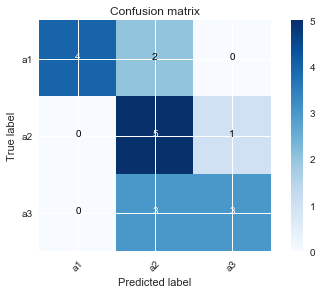

In [258]:
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(accuracy_score(actual, predicted))
print(classification_report(actual, predicted, target_names=test_actions))
cnf_matrix = confusion_matrix(actual, predicted)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=test_actions,
                      title='Confusion matrix')

As can see predictions are not very good, a1 and a3 are confused, therefore more sensor data needed

### Lets try to do Inertial model

In [45]:
def load_inertial_data():
    dir_path = "Inertial"
    files = os.listdir(dir_path)
    all_data = [] 
    for ii, file in enumerate(files, 1):
        #print(ii, file)
        if file.endswith(".mat"):
            mat_contents = sio.loadmat(dir_path+'/'+file)
            d_skel=mat_contents["d_iner"]
            action = file.split("_")[0]
            all_data.append((d_skel,action))
    print(len(all_data))
    return all_data

In [46]:
all_data_iner = load_inertial_data()
training_data_iner, testing_data_iner = split_data(all_data_iner,all_actions,26)

861


In [47]:
print("training.." , len(training_data_iner))
print("testing.." , len(testing_data_iner))

training.. 702
testing.. 159


In [48]:
def get_hmm_formatted_features_inertial(records,action):
    x_contatinated = np.zeros((1,6))
    lengths=[]
    
    actions = fetch_training_data_by_action(records,action)
    action_features,_ = zip(*actions)
    print(len(action_features))
    print(action_features[0].shape)
    
    
    for subject_action in list(action_features):
        lengths.append(subject_action.shape[0])
        x_contatinated = np.append(x_contatinated,subject_action,axis=0)
#         x_contatinated.append(subject_action)
#         for i in range(subject_action.shape[1]):
#             x_contatinated.append(subject_action) #subject_action[:,:,i].reshape(-1,))
    #len(x_contatinated)
    print(x_contatinated[0])
    print(x_contatinated[1])
    x_contatinated = np.delete(x_contatinated, 0, axis=0)
    print(np.array(x_contatinated).shape)
    print(x_contatinated[0])
    print(x_contatinated[1])
    print(lengths)
    return np.array(x_contatinated),lengths

In [49]:
iner_X,iner_lengths = get_hmm_formatted_features_inertial(training_data_iner,'a1')
iner_model, iner_logL = train_an_action('a1', 3, iner_X ,iner_lengths)

26
(180, 6)
[ 0.  0.  0.  0.  0.  0.]
[-0.98 -0.24  0.2  -3.39  0.7  -0.27]
(4140, 6)
[-0.98 -0.24  0.2  -3.39  0.7  -0.27]
[-0.99 -0.29  0.18 -3.91  0.46  0.55]
[180, 190, 156, 149, 170, 197, 143, 157, 143, 187, 125, 150, 160, 142, 160, 127, 180, 145, 165, 158, 189, 183, 146, 154, 141, 143]


In [50]:
print("Number of states trained in model for {} is {}".format('a1', iner_model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for a1 is 3
logL = 160714.10661357493


### Load  Depth Data

In [51]:
def load_depth_data():
    dir_path = "Depth"
    files = os.listdir(dir_path)
    all_data = [] 
    for ii, file in enumerate(files, 1):
        #print(ii, file)
        if file.endswith(".mat"):
            mat_contents = sio.loadmat(dir_path+'/'+file)
            d_skel=mat_contents["d_depth"]
            action = file.split("_")[0]
            all_data.append((d_skel,action))
    print(len(all_data))
    return all_data

In [52]:
all_data_depth = load_depth_data()
training_data_depth, testing_data_depth = split_data(all_data_depth,all_actions,26)

861


In [112]:
print("training.." , len(training_data_depth))
print("testing.." , len(testing_data_depth))

training.. 702
testing.. 159


In [54]:
from scipy import signal
import skimage.measure

In [106]:
def train_an_action_depth(action, num_hidden_states, features,lengths):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)  
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000,random_state=123,params="f").fit(features,lengths)
    logL = model.score(features,lengths)
    return model, logL

In [278]:
def get_hmm_formatted_features_depth(records,action):
    x_contatinated = []
    lengths=[]
    
    actions = fetch_training_data_by_action(records,action)
    action_features,_ = zip(*actions)
    print(len(action_features))
    print(action_features[0].shape)
    w_k_v = np.array([[3,0,-3],[10,0,-10],[3,0,-3]]) #Sobel–Feldman 
    w_k_h = np.array([[3,10,3],[0,0,0],[-3,-10,-3]])
    
    
    for subject_action in list(action_features):
        lengths.append(subject_action.shape[2])
        
        
        
        for i in range(subject_action.shape[2]):
            #print(i)
            lay1_b = subject_action[:,:,i]
            if i==0:
                plt.imshow(lay1_b)
            for j in range(4):
                #print(lay1_b.shape, w_k_v.shape,subject_action[:,:,i].shape)
                lay1v = signal.convolve2d(lay1_b, w_k_v, 'valid')
                lay1h = signal.convolve2d(lay1_b, w_k_v, 'valid')
                #print(lay1v.shape)
                #lay1_c = np.stack([lay1v,lay1h], axis=2)
                lay1_b = skimage.measure.block_reduce(lay1v, (2,2), np.max)
                
            #print(subject_action[:,:,i].shape)
            print("final shape",lay1_b.shape)
            
            x_contatinated.append(lay1_b.reshape(-1,))
    #len(x_contatinated)
    #print(x_contatinated[0])
    #print(x_contatinated[1])
    #x_contatinated = np.delete(x_contatinated, 0, axis=0)
    print(np.array(x_contatinated).shape)
    #print(x_contatinated[0])
    #print(x_contatinated[1])
    print(lengths)
    return np.array(x_contatinated),lengths

26
(240, 320, 56)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14,

final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (

final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (

final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (14, 19)
final shape (

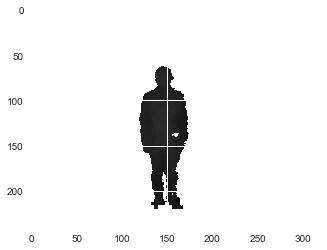

In [279]:
depth_X,depth_lengths = get_hmm_formatted_features_depth(training_data_depth,'a1')


In [110]:
depth_model, depth_logL = train_an_action_depth('a1', 3, depth_X ,depth_lengths)

In [111]:
print("Number of states trained in model for {} is {}".format('a1', depth_model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for a1 is 3
logL = 160714.10661357493


6
(240, 320, 50)
(369, 54)
[50, 69, 74, 54, 55, 67]
6
(140, 6)
[ 0.  0.  0.  0.  0.  0.]
[ -0.93  -0.26  -0.1  -22.11  -5.1   -3.18]
(859, 6)
[ -0.93  -0.26  -0.1  -22.11  -5.1   -3.18]
[ -0.94  -0.26  -0.12 -29.1   -6.93  -3.15]
[140, 165, 145, 142, 134, 133]
6
(20, 3, 58)
(57, 20)
length 6
(328, 20)
[57, 46, 54, 59, 57, 55]


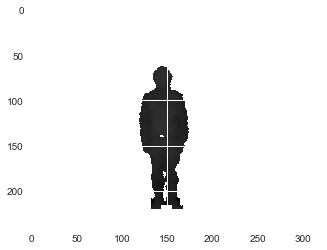

In [274]:
test_AsX,test_A3sL = get_hmm_formatted_features_depth(testing_data_depth,'a2')
pr1 = predicted([test_AsX[0],test_AsX[1]])
test_AsX,test_A3sL = get_hmm_formatted_features_inertial(testing_data_iner,'a2')
pr2 = iner_model.score([test_AsX[0],test_AsX[1]])
test_AsX,test_A3sL = get_hmm_formatted_features(testing_data,20,'a2')
pr3 = model.score([test_AsX[0],test_AsX[1]])

In [275]:
print(pr1)
print(pr2)
print(pr3)

-1325.13435189
-27.6809350721
164.827733009


In [270]:
print((pr1-np.mean(pr1))/(np.sqrt(np.var(pr1))))
print((pr2-np.mean(pr2))/(np.sqrt(np.var(pr2))))
print((pr1-np.mean(pr3))/(np.sqrt(np.var(pr3))))

[[ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]
 ..., 
 [ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]]
[[-0.71  1.41 -0.71]
 [-0.71  1.41 -0.71]]
[[ 1.41  1.41  1.41]
 [ 1.41  1.41  1.41]
 [ 1.41  1.41  1.41]
 ..., 
 [ 1.41  1.41  1.41]
 [ 1.41  1.41  1.41]
 [ 1.41  1.41  1.41]]


/usr/local/anaconda3/envs/nus/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


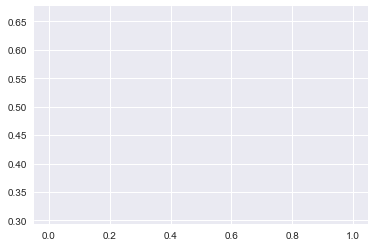

In [264]:
plt.plot(pr3, mlab.normpdf(pr3, np.mean(pr3), math.sqrt(np.var(pr3))), c=colour)
plt.grid(True)

In [156]:
print(test_AsX[0:2].shape)
model.predict_proba(test_AsX,test_A3sL)

(2, 60)


/usr/local/anaconda3/envs/nus/lib/python3.6/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/usr/local/anaconda3/envs/nus/lib/python3.6/site-packages/hmmlearn/base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


array([[  1.00e+000,   2.17e-187,   0.00e+000],
       [  1.00e+000,   3.12e-189,   0.00e+000],
       [  1.00e+000,   2.12e-189,   0.00e+000],
       ..., 
       [  1.00e+000,   1.64e-202,   0.00e+000],
       [  1.00e+000,   1.25e-202,   0.00e+000],
       [  1.00e+000,   1.79e-202,   0.00e+000]])